In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam

In [2]:
# Mount Google Drive as dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#unzip the file
!unzip /content/drive/MyDrive/HKBU/CVPR/ColabFiles/faceDataset.zip

Archive:  /content/drive/MyDrive/HKBU/CVPR/ColabFiles/faceDataset.zip
   creating: face dataset/
   creating: face dataset/test/
   creating: face dataset/test/fake/
  inflating: face dataset/test/fake/easy_105_1100.jpg  
  inflating: face dataset/test/fake/easy_111_1101.jpg  
  inflating: face dataset/test/fake/easy_112_1001.jpg  
  inflating: face dataset/test/fake/easy_11_1111.jpg  
  inflating: face dataset/test/fake/easy_123_0100.jpg  
 extracting: face dataset/test/fake/easy_124_1110.jpg  
  inflating: face dataset/test/fake/easy_129_1111.jpg  
  inflating: face dataset/test/fake/easy_131_1001.jpg  
  inflating: face dataset/test/fake/easy_138_0101.jpg  
  inflating: face dataset/test/fake/easy_141_0111.jpg  
  inflating: face dataset/test/fake/easy_142_1111.jpg  
  inflating: face dataset/test/fake/easy_155_0011.jpg  
  inflating: face dataset/test/fake/easy_156_0010.jpg  
  inflating: face dataset/test/fake/easy_159_1111.jpg  
  inflating: face dataset/test/fake/easy_15_0011.jp

In [4]:
# Define the path to your dataset
dataset_path = '/content/face dataset'

In [5]:
img_size = 128
num_classes =2

In [6]:
#defining folder for train, validation and testing
train_folder = os.path.join(dataset_path, "train")
validation_folder = os.path.join(dataset_path, "valid")
test_folder = os.path.join(dataset_path, "test")

#defining sub-folders for real and fake images
fake_folder = "fake"
real_folder = "real"

In [7]:
#defining a function to perform ela
def convert_to_ela(image_path, quality):
  original_image = cv2.imread(image_path)

  #get image dimensions
  height, width, channels = original_image.shape
  #save the image with temporary format and lower quality
  temp_image_name = "/content/temp_image_" + str(quality) + ".jpg"
  #save image with specified quality
  cv2.imwrite(temp_image_name, original_image, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
  temp_image = cv2.imread(temp_image_name)

  os.remove(temp_image_name)

  #calculate difference
  diff_image = cv2.absdiff(original_image, temp_image)
  #return diffrence image as ela image
  return diff_image

In [8]:
#defining function to load and pre-process the images from train and validation folder with augmentation
def load_and_preprocess_images(folder):
  #initialise empty list to store images and labesl
  images = []
  labels = []

  #loop over subfolders for fake and real images
  for subfolder in [fake_folder, real_folder]:
    subfolder_path = os.path.join(folder, subfolder)
    print("Subfolder path:", subfolder_path)
    #loop over image files in the sub-folder
    for image_file in os.listdir(subfolder_path):
      image_path = os.path.join(subfolder_path, image_file)
      #load original image
      original_image = cv2.imread(image_path)
      image = cv2.resize(original_image, (128, 128)) #resizing the image to 128X128 pixels
      #convert to tensor
      tf_image = tf.convert_to_tensor(image)

      #functions for augmentation
      aug_lr_img = (tf.image.flip_left_right(tf_image))/255
      aug_ud_img = (tf.image.flip_up_down(tf_image))/255
      aug_90_img = (tf.image.rot90(tf_image, k=1))/255
      aug_brt_img = (tf.image.random_brightness(tf_image, max_delta=0.5))/255
      aug_cont_img = (tf.image.random_contrast(tf_image, 0.1, 0.5))/255
      aug_sat_img = (tf.image.random_saturation(tf_image, 5,10))/255

      #convert augmented tensor into numpy array
      ori_img = tf_image/255
      images.append(ori_img.numpy())
      images.append(aug_lr_img.numpy())
      images.append(aug_ud_img.numpy())
      images.append(aug_90_img.numpy())
      images.append(aug_brt_img.numpy())
      images.append(aug_cont_img.numpy())
      images.append(aug_sat_img.numpy())

      #add labels for the images
      for i in range(7):
        label = 0 if subfolder == fake_folder else 1
        labels.append(label)

  #convert the images and lables list to numpy array
  images = np.array(images, dtype='float32')
  labels = np.array(labels)

  #return images and labels array
  return images, labels

In [9]:
#defining function to load and pre-process the images from test folder without augmentation
def load_and_preprocess_test_images(folder):
  #initialise empty list to store images and labesl
  images = []
  labels = []
  #loop over subfolders for fake and real images
  for subfolder in [fake_folder, real_folder]:
    subfolder_path = os.path.join(folder, subfolder)
    print("Subfolder path:", subfolder_path)
    #loop over image files in the sub-folder
    for image_file in os.listdir(subfolder_path):
      image_path = os.path.join(subfolder_path, image_file)
      original_image = cv2.imread(image_path)
      image = cv2.resize(original_image, (128, 128)) #resizing the image to 128X128 pixels
      #convert to tensor
      tf_image = tf.convert_to_tensor(image)
      image = tf_image/255 #normalise the pixel values
      images.append(image.numpy()) #append the image to the images list
      label = 0 if subfolder == fake_folder else 1
      labels.append (label)

  #convert the images and lables list to numpy array
  images = np.array(images, dtype='float32')
  labels = np.array(labels)

  #return images and labels array
  return images, labels

In [10]:
#load and preprocess the images from the train, test and valid folders
train_images, train_labels = [],[]
test_images, test_labels = [],[]
validate_images, validate_labels = [],[]

In [11]:
#load and preprocess the images from the train, test and valid folders
train_images, train_labels = load_and_preprocess_images(train_folder)
test_images, test_labels = load_and_preprocess_test_images(test_folder)
validate_images, validate_labels = load_and_preprocess_images(validation_folder)

Subfolder path: /content/face dataset/train/fake
Subfolder path: /content/face dataset/train/real
Subfolder path: /content/face dataset/test/fake
Subfolder path: /content/face dataset/test/real
Subfolder path: /content/face dataset/valid/fake
Subfolder path: /content/face dataset/valid/real


In [12]:
print(train_images.shape)
print(train_labels.shape)
print(validate_images.shape)
print(validate_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(9513, 128, 128, 3)
(9513,)
(1197, 128, 128, 3)
(1197,)
(511, 128, 128, 3)
(511,)


In [15]:
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)
validate_images, validate_labels = shuffle(validate_images, validate_labels)

In [16]:
print(train_labels)

[0 1 1 ... 0 0 0]


In [19]:
def build_model():
  #definde CNN architecture
  model = models.Sequential()
  model.add(layers.Conv2D (32, (3,3), activation='relu', input_shape=(128, 128,3)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(256, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid'))

  #compile the model with binary cross-entropy as the loss function and adam as optimiser
  model.compile(
      loss='binary_crossentropy',
      optimizer=Adam(learning_rate=0.0001),
      metrics=['accuracy']
      )
  return model

In [20]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)      

In [21]:
EPOCHS = 30
BATCH_SIZE = 30

In [22]:
#training the model on train images and labels using valid images and lables as validation data
history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (validate_images, validate_labels)  )

Epoch 1/30
318/318 [==============================] - 23s 31ms/step - loss: 0.6924 - accuracy: 0.5235 - val_loss: 0.6979 - val_accuracy: 0.3576
Epoch 2/30
318/318 [==============================] - 9s 27ms/step - loss: 0.6876 - accuracy: 0.5497 - val_loss: 0.7076 - val_accuracy: 0.3810
Epoch 3/30
318/318 [==============================] - 9s 28ms/step - loss: 0.6756 - accuracy: 0.5733 - val_loss: 0.6701 - val_accuracy: 0.6190
Epoch 4/30
318/318 [==============================] - 8s 26ms/step - loss: 0.6614 - accuracy: 0.6064 - val_loss: 0.6746 - val_accuracy: 0.5798
Epoch 5/30
318/318 [==============================] - 9s 27ms/step - loss: 0.6556 - accuracy: 0.6107 - val_loss: 0.6886 - val_accuracy: 0.5439
Epoch 6/30
318/318 [==============================] - 9s 27ms/step - loss: 0.6449 - accuracy: 0.6225 - val_loss: 0.6605 - val_accuracy: 0.6282
Epoch 7/30
318/318 [==============================] - 9s 27ms/step - loss: 0.6333 - accuracy: 0.6367 - val_loss: 0.6477 - val_accuracy: 0.634

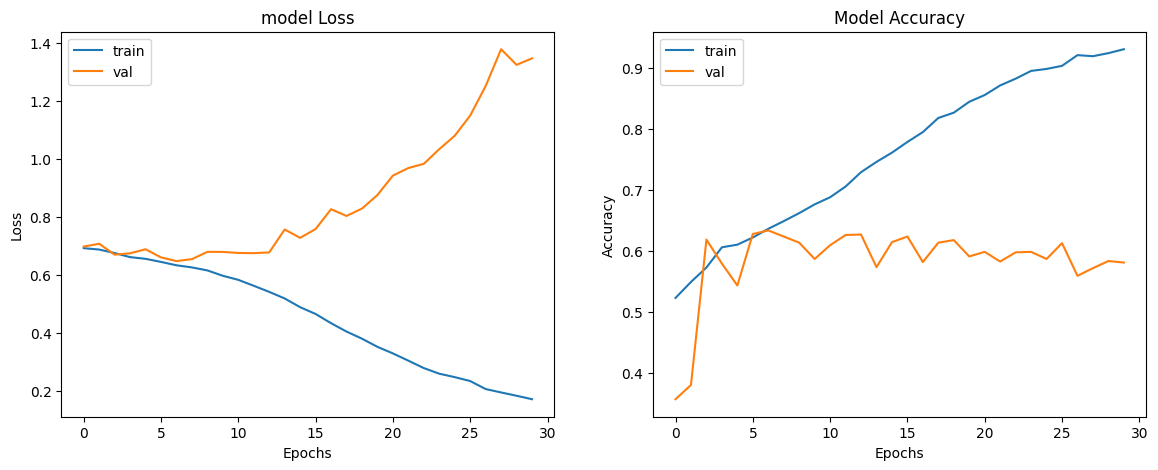

In [23]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [24]:
y_pred = model.predict(test_images)

16/16 [==============================] - 1s 16ms/step


In [25]:
#predicting the lables for test_images
test_pred = model.predict(test_images)

print(test_pred)

16/16 [==============================] - 0s 8ms/step
[[9.00838673e-01]
 [9.75458086e-01]
 [1.89980175e-02]
 [9.74580944e-01]
 [2.79035012e-04]
 [9.89635646e-01]
 [1.12858657e-02]
 [1.05040725e-02]
 [8.43802452e-01]
 [9.62160051e-01]
 [1.46391849e-05]
 [2.17536032e-01]
 [4.74324189e-02]
 [9.84147042e-02]
 [9.97796178e-01]
 [9.98304248e-01]
 [9.77509499e-01]
 [3.13592493e-04]
 [9.99903321e-01]
 [5.45011103e-01]
 [7.11069035e-04]
 [2.41247505e-01]
 [8.34846497e-02]
 [9.97252285e-01]
 [5.70598364e-01]
 [7.09199812e-05]
 [4.79373038e-01]
 [1.57062598e-02]
 [7.56034374e-01]
 [1.00000000e+00]
 [1.36704266e-01]
 [5.19687712e-01]
 [5.90654672e-04]
 [3.82531609e-04]
 [6.69863522e-02]
 [9.64324892e-01]
 [2.27370393e-03]
 [9.09334898e-01]
 [5.30650243e-02]
 [9.99998927e-01]
 [8.74416113e-01]
 [9.96313870e-01]
 [9.98960495e-01]
 [7.88915515e-01]
 [6.65534317e-01]
 [1.97903812e-02]
 [8.45171273e-01]
 [5.18571079e-01]
 [9.99965668e-01]
 [5.84809601e-01]
 [1.90085061e-02]
 [9.89073813e-01]
 [4.5791354

In [26]:
#convert the predicted lables to binary values
test_pred = np.where(test_pred >0.5, 1, 0)

In [27]:
print(test_labels)

[1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1
 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1
 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1
 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0
 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0
 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0
 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1
 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1
 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0
 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1
 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1
 1 1 0 1 1 1 1 0 1 1 0 1 

In [28]:
print(test_pred)

[[1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]


In [29]:
#calculate the accuracy, precision, recall, and f1-score
accuracy = accuracy_score(test_labels, test_pred)
precision = precision_score(test_labels, test_pred)
recall = recall_score(test_labels, test_pred)
f1 = f1_score(test_labels, test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.5636007827788649
Precision: 0.6475095785440613
Recall: 0.5633333333333334
F1-score: 0.6024955436720142


In [30]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=[0,1],
        y=[0,1],
        name="TPR = FPR",
        line=dict(color="black", dash="dash")
    )
)

In [31]:
def PlotRocAuc(test_labels, test_pred, color, model_name):
  fpr, tpr, thresholds = roc_curve(test_labels, test_pred)
  auc_score = roc_auc_score(test_labels, test_pred)
  fig.add_trace(
      go.Scatter(
          x= fpr,
          y=tpr,
          name=f"{model_name}(AUC={auc_score})",
          marker=dict(color=color)
      )
  )

In [32]:
PlotRocAuc(test_labels, test_pred, "red", "model")

fig.update_layout(title="Base CNN",
                  xaxis_title="False Positive Rate",
                  yaxis_title="True Positive Rate")
fig.show()

In [33]:
y_pred_class = test_pred > 0.5
cm = confusion_matrix(test_labels, y_pred_class)
tn, fp, fn, tp = cm.ravel()

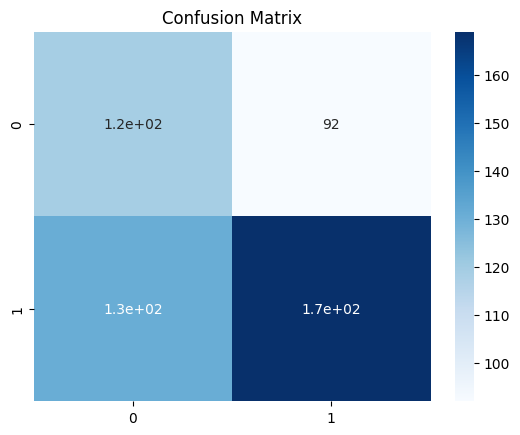

In [34]:
#Plot the confusion matrix
sns.heatmap (cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()